# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
<200 words

My initial project plan was to study cancel culture on Twitter, by seeing whether cancelling individuals actually carries any sticking power. I was going to use text analysis to generate different dimensions for categorizing participants (for example, analyze tweets to gauge whether someone is a feminist), and  create a model that could predict what tweets are most likely to get cancelled. However, I would  need access to Twitter's premium API.

Instead, I might do an MTurk study on music perception and emotion across cultures (which is what I did on a much smaller scale here, for this assignment). More specifically, I would give participants different song clips and ask them to fill out a likert-scale measure (potentially, an adapted version of this one: https://www.researchgate.net/figure/5-The-Geneva-Emotional-Music-Scales-GEMS-derived-from-confi-rmatory-factor-analyses_tbl4_260204368). Would include an open ended component so we can do sentiment analysis as well.

Some other ideas I'm toying with are: studying tone in Wikipedia articles that are supposed to be presenting topics neutrally (seeing if they are or if the piece is clearly skewed); I would use the wikipedia corpus Dr. Evans was talking about. I'm planning on solidifying a topic once we meet during office hours.


## ***Why?***

MTurk idea: I'm interested in music cognition and emotion across cultures, and to want to probe whether certain musical emotion perceptions are invariant across cultures (e.g., Juslin, 2012; Higgins, 2012). This research would help in determining whether there is some universality to certain emotions (the jury's currently out on this). There parallels between how language and music are processed in the brain (Jackendoff, 2009), so insights from music cognition research could inform research on language cognition. These findings can also influence music therapy research, which obviously has manifold benefits.

Cancel culture idea: Will help us understand whether cancelling people actually "works" (the backfire effect suggests that it might not), and could inform strategies on how to approach conflict and justice-seeking online. Could also help with predicting what tweets are more likely to be cancelled in the future and why, and how cancelling works in the context of social network theory.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

*Some of this is already covered in the "what/why" section"

MTurk idea: I decided to use a Likert scale with multiple dimensions to capture emotion perception in music, and would want to implement an open ended component too. I also specifically chose/will choose songs that don't have vocals, or songs where the vocals are obscured or are otherwise unintelligble (maybe in a different langauge). My rationale for this is that I want to focus on melody perception, extricating the confounds of lyrics from it. As stated before, I ran this study on a small sample for this assignment but would scale it up on a larger platform like MTurk for further analysis. The limitations of a likert scale include its discreteness (participants can't choose values in between other values), but I'm hoping that the free response component will give participants more room to explain their choices. Another limitation is that we can't extricate participant history from their responses (ex., a participant might find a song sad because it played during a traumatic time in their life, not because the song is inherently sad to them). The social actors here are participants across a diverse set of cultures, since I'm studying the universality of emotion (will operationalize later).

* See survey in my homework response below

# The rest of my answers are below the example annotation dataset explanation; I didn't delete your example code because I wanted to be able to refer to it while doing the homework. I've written my answers as comments throughout the code, as well as a snippet at the beginning of the "your turn" section

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [5]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [42]:
x = np.loadtxt('/Users/Sruti/Desktop/testdata_numerical.txt')
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [44]:
x

array([[ 2.,  3.,  4., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 3.,  3.,  2., ..., -1., -1., -1.],
       ...,
       [ 3.,  3., -1., ..., -1., -1.,  2.],
       [ 3.,  3., -1., ..., -1., -1.,  4.],
       [ 2.,  2., -1., ..., -1., -1.,  1.]])

Interrogate the AnnotationsContainer object.

In [11]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [12]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [13]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [14]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


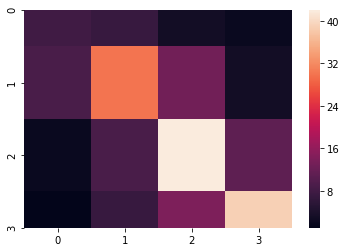

In [15]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 1. 0.]
 [1. 1. 1. 0.]]


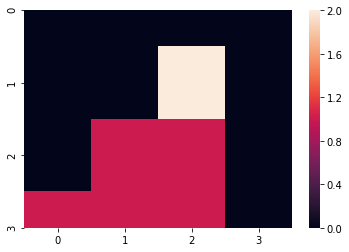

In [60]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,5],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [16]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [17]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [11]:
krippendorffs_alpha(anno.annotations[::]) 

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [18]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [19]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


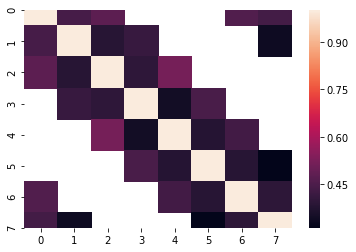

In [20]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [21]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [22]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [23]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

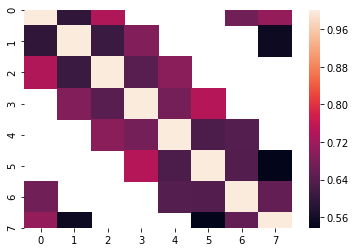

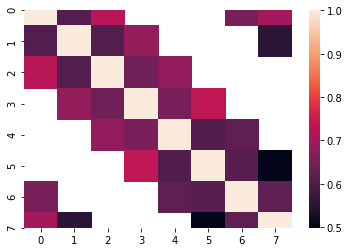

In [24]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [25]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [76]:
x = np.loadtxt('/Users/Sruti/Desktop/practice_surveyscores.txt')
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [75]:
#converting data to the right format so I can put it back into text file
#(columns = participants, rows = responses)
arr1 = [[1, 3, 3, 2, 0, 4, 4, 1, 1, 3, 1, 2], 
        [2, 2, 0, 3, 2, 1, 2, 1, 2, 0, 0, 4], 
        [1, 3, 1, 1, 0, 4, 2, 1, 0, 3, 1, 1], 
        [1, 1, 3, 2, 2, 2, 3, 3, 3, 4, 0, 4], 
        [2, 3, 1, 2, 1, 2, 3, 1, 3, 1, 1, 3], 
        [3, 1, 1, 2, 2, 0, 0, 3, 0, 4, 1, 2], 
        [3, 2, 3, 2, 2, 2, 3, 1, 3, 3, 2, 2], 
        [3, 1, 2, 1, 3, 1, 2, 1, 3, 2, 1, 4], 
        [1, 3, 4, 0, 0, 2, 3, 3, 3, 1, 0, 1]]
np.transpose(arr1)

array([[1, 2, 1, 1, 2, 3, 3, 3, 1],
       [3, 2, 3, 1, 3, 1, 2, 1, 3],
       [3, 0, 1, 3, 1, 1, 3, 2, 4],
       [2, 3, 1, 2, 2, 2, 2, 1, 0],
       [0, 2, 0, 2, 1, 2, 2, 3, 0],
       [4, 1, 4, 2, 2, 0, 2, 1, 2],
       [4, 2, 2, 3, 3, 0, 3, 2, 3],
       [1, 1, 1, 3, 1, 3, 1, 1, 3],
       [1, 2, 0, 3, 3, 0, 3, 3, 3],
       [3, 0, 3, 4, 1, 4, 3, 2, 1],
       [1, 0, 1, 0, 1, 1, 2, 1, 0],
       [2, 4, 1, 4, 3, 2, 2, 4, 1]])

In [77]:
x = np.load

In [78]:
anno.annotations

array([[1, 2, 1, 1, 2, 3, 3, 3, 1],
       [3, 2, 3, 1, 3, 1, 2, 1, 3],
       [3, 0, 1, 3, 1, 1, 3, 2, 4],
       [2, 3, 1, 2, 2, 2, 2, 1, 0],
       [0, 2, 0, 2, 1, 2, 2, 3, 0],
       [4, 1, 4, 2, 2, 0, 2, 1, 2],
       [4, 2, 2, 3, 3, 0, 3, 2, 3],
       [1, 1, 1, 3, 1, 3, 1, 1, 3],
       [1, 2, 0, 3, 3, 0, 3, 3, 3],
       [3, 0, 3, 4, 1, 4, 3, 2, 1],
       [1, 0, 1, 0, 1, 1, 2, 1, 0],
       [2, 4, 1, 4, 3, 2, 2, 4, 1]])

In [79]:
anno.labels

[0.0, 1.0, 2.0, 3.0, 4.0]

In [80]:
anno.missing_values
#I don't have any missing values, but if I did they would be labelled "999"

[]

# Survey description

* I sent participants (n = 9) 3 ~1 minute clips, and asked the following question about each of them. The songs I extracted clips from were Human Sadness by Julian Casablancas, Piano Quartet in A Minor by Gustav Mahler, and Ab Tohe Jane Naa Doongi from Bajirao Mastani.

When you listened to track a, to what did degree did you feel the following four emotions?
* Happiness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Sadness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Tension-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Peacefulness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)

When you listened to track b, to what did degree did you feel the following four emotions?


* Happiness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Sadness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Tension-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Peacefulness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)


When you listened to track c, to what did degree did you feel the following four emotions?
* Happiness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Sadness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Tension-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)
* Peacefulness-  
Not at all (0) Small degree (1) Moderate degree (2) High degree (3) Very high degree (4)

# <span style="color:pink"> Choosing inter-rater reliability measure:
    
* Scott’s pi is a measure of intercoder reliability in communication studies for nominal level data with just two coders; for more than 2 coders, use Fleiss' kappa 

* Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories. Meant for categorical data

* Krippendorff's alpha is applicable to any number of coders, each assigning one value to one unit of analysis, to incomplete (missing) data, to any number of values available for coding a variable, to binary, nominal, ordinal, interval, ratio, polar, and circular metrics (levels of measurement), and it adjusts itself to small sample sizes of the reliability data. The virtue of a single coefficient with these variations is that computed reliabilities are comparable across any numbers of coders, values, different metrics, and unequal sample sizes.


All this considered, Krippendorf's alpha would be the most appropriate given that I'm working with Likert-Scale data. However, as you can see below, my inter rater reliability is very low. This preliminary analysis indicates very diverse emotion perceptions generated by music.

What does this means for the reliability of human assessments regarding content in your domain: given the subjectivity of the emotions music elicits, the reliability is low. However, with more specified and varied measures to supplement the Likert scale, we might be able to increase reliability. 

In [81]:
#  frequency of codes
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.12037037, 0.28703704, 0.25      , 0.25925926, 0.08333333])

In [84]:
anno.annotations[:]

array([[1, 2, 1, 1, 2, 3, 3, 3, 1],
       [3, 2, 3, 1, 3, 1, 2, 1, 3],
       [3, 0, 1, 3, 1, 1, 3, 2, 4],
       [2, 3, 1, 2, 2, 2, 2, 1, 0],
       [0, 2, 0, 2, 1, 2, 2, 3, 0],
       [4, 1, 4, 2, 2, 0, 2, 1, 2],
       [4, 2, 2, 3, 3, 0, 3, 2, 3],
       [1, 1, 1, 3, 1, 3, 1, 1, 3],
       [1, 2, 0, 3, 3, 0, 3, 3, 3],
       [3, 0, 3, 4, 1, 4, 3, 2, 1],
       [1, 0, 1, 0, 1, 1, 2, 1, 0],
       [2, 4, 1, 4, 3, 2, 2, 4, 1]])

[[1. 0. 0. 0. 0.]
 [1. 3. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 0. 2. 0.]
 [0. 0. 1. 0. 1.]]


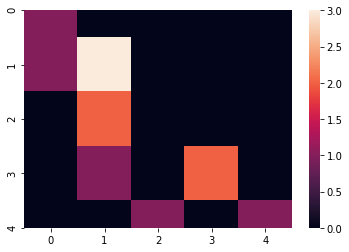

In [85]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,2],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()
#Interpretation of confusion matrix for two individuals:
#These two individuals agreed on 7, and disagreed on 5 questions. Can generate for all pairs within dataset.
#If I want to see more, would need to create a for loop (get every combination of pairs)

In [141]:
fleiss_kappa(anno.annotations[::]) #Not necessarily appropriate for this type of data, but generated to see output

0.048657718120805354

In [162]:
krippendorffs_alpha(anno.annotations[::]) #well below 0.67, very low inter rater reliability.

0.06956521739130417

In [140]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,2]) #Comparing across two individuals, moderate reliability

0.4444444444444445

In [90]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)
#Comparing all the pairs of participants (and their answers) -> IRR

[[ 1.         -0.11864407  0.44444444  0.04424779  0.09433962  0.06086957
   0.25663717 -0.12149533  0.04424779]
 [-0.11864407  1.         -0.01694915  0.06896552 -0.04347826 -0.18918919
  -0.00934579  0.16521739 -0.1092437 ]
 [ 0.44444444 -0.01694915  1.         -0.12820513  0.06796117  0.03571429
   0.01639344  0.07692308  0.12727273]
 [ 0.04424779  0.06896552 -0.12820513  1.          0.11926606  0.27586207
   0.30769231  0.02702703  0.36842105]
 [ 0.09433962 -0.04347826  0.06796117  0.11926606  1.          0.03571429
   0.16831683 -0.10204082  0.23636364]
 [ 0.06086957 -0.18918919  0.03571429  0.27586207  0.03571429  1.
   0.15044248  0.04424779 -0.15789474]
 [ 0.25663717 -0.00934579  0.01639344  0.30769231  0.16831683  0.15044248
   1.         -0.01886792  0.06086957]
 [-0.12149533  0.16521739  0.07692308  0.02702703 -0.10204082  0.04424779
  -0.01886792  1.         -0.16814159]
 [ 0.04424779 -0.1092437   0.12727273  0.36842105  0.23636364 -0.15789474
   0.06086957 -0.16814159  1. 

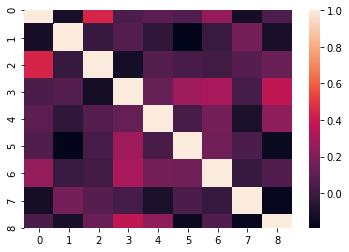

In [91]:
ax = seaborn.heatmap(m)
plt.show()
#Plots pairwise cohen's kappa relationships throughout dataset (for all the pairs)
#Not sure why negative cohen's kappa values aren't showing up on this heatmap, given the values
#calculated in the cells below: 
#The pairwise matrix is showing us the inter rater reliability for each permutation of pairs of individuals within my dataset. In other words, it's comparing all the possible combinations of pairs within my sample and looking at the inter rater reliability (using Cohen's K).

The pairwise matrix is showing us the inter rater reliability for each permutation of pairs of individuals within my dataset. In other words, it's comparing all the possible combinations of pairs within my sample and looking at the inter rater reliability (using Cohen's K).

In [92]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)
#Below is the average Cohens Kappa value across pairs across the dataset. 
#0.05 corresponds to "none to slight agreement"

0.058721149706292275

In [93]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.15384615384615374

In [94]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)
#0.05 corresponds to "none to slight agreement, across pairs

0.056866538517170086

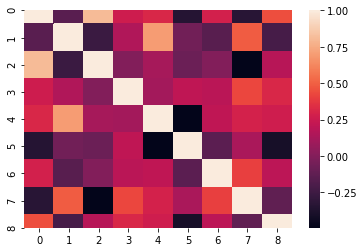

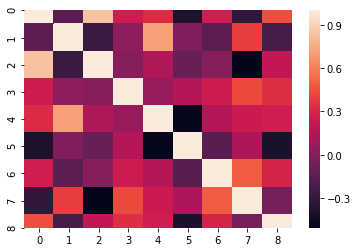

In [142]:
#The heatmaps show all the correlations within the data within all possible pairs. 
#The closer to 1 (white) means that the participants had more overlap, which is desirable.
#For example, in the first column, participant 0 and participant 2 have a lot of overlap in their answers overall
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [95]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.09031269985436276 0.09131138694416467


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [99]:
# create a new instance of model, with 5 label classes
model = ModelB.create_initial_state(5, 9) #I have five classes and nine participants
# other model parameters are initialized from the model prior
print(model.theta) #will use later when extrapolating "true" answers to these questions
#estimate parameters based on our data
print(model.log_likelihood(anno.annotations)) 

[[[0.780922   0.08115122 0.07625948 0.00085284 0.06081446]
  [0.18905873 0.63544852 0.12894451 0.03788098 0.00866727]
  [0.03272836 0.1186338  0.57145909 0.22304651 0.05413223]
  [0.06198766 0.16392047 0.05443252 0.638521   0.08113834]
  [0.0762461  0.00186579 0.03976931 0.17542279 0.70669602]]

 [[0.67969368 0.1740431  0.10438662 0.02600798 0.01586862]
  [0.16827001 0.59558928 0.18170189 0.03981405 0.01462478]
  [0.11722797 0.16084846 0.50546704 0.16833795 0.04811859]
  [0.05055227 0.05168411 0.10164986 0.69907885 0.09703492]
  [0.00569565 0.06500207 0.04247799 0.22169344 0.66513085]]

 [[0.73306926 0.06925336 0.05577902 0.0660085  0.07588985]
  [0.12054026 0.68512629 0.05233862 0.12379382 0.01820101]
  [0.01054388 0.13673677 0.55174277 0.22327452 0.07770206]
  [0.01768304 0.0519551  0.25153437 0.61347251 0.06535498]
  [0.00137076 0.14415764 0.11373177 0.1188282  0.62191164]]

 [[0.73725967 0.11463369 0.06097134 0.05866571 0.02846958]
  [0.13559968 0.58845744 0.12850478 0.06900176 0.0

In [164]:
print(model.theta)
#MAP estimates generated below

[0.66137431 0.18608489 0.60270203 0.51586435 0.68329285 0.45278202
 0.80068866 0.35419926 0.43746123]


In [158]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 5, burn_in_samples=100, thin_samples=3)
samples

array([[0.55580278, 0.14875217, 0.44707491, 0.65450643, 0.69395482,
        0.36702909, 0.80136392, 0.20641127, 0.46487972],
       [0.55580278, 0.14875217, 0.44707491, 0.65450643, 0.69395482,
        0.36702909, 0.80136392, 0.20641127, 0.46487972],
       [0.55580278, 0.14875217, 0.44707491, 0.65450643, 0.69395482,
        0.36702909, 0.80136392, 0.20641127, 0.46487972],
       [0.55580278, 0.14875217, 0.44707491, 0.65450643, 0.69395482,
        0.36702909, 0.80136392, 0.20641127, 0.46487972],
       [0.55580278, 0.14875217, 0.44707491, 0.65450643, 0.69395482,
        0.36702909, 0.80136392, 0.20641127, 0.46487972]])

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [103]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.21513238e-001 7.16832430e-001 1.21088589e-001 4.05657436e-002
   3.78574144e-084]
  [7.32770242e-002 1.14985231e-001 6.25157423e-001 1.12485097e-001
   7.40952243e-002]
  [0.00000000e+000 7.79981466e-002 1.12157405e-001 6.62525585e-001
   1.47318864e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.61372377e-001 6.45477367e-001 1.52749810e-001 4.04004457e-002
   0.00000000e+000]
  [3.70624766e-002 1.47427617e-001 5.95793158e-001 1.47381469e-001
   7.23352797e-002]
  [7.36481177e-002 3.69553575e-002 2.23370558e-001 5.53868562e-001
   1.12157405e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.21521604e-001 7.16880438e-001 1.21

In [166]:
print(model.theta)

[0.66137431 0.18608489 0.60270203 0.51586435 0.68329285 0.45278202
 0.80068866 0.35419926 0.43746123]


In [104]:
model = ModelB.create_initial_state(5, 9)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.21513238e-001 7.16832430e-001 1.21088589e-001 4.05657436e-002
   3.78574144e-084]
  [7.32770242e-002 1.14985231e-001 6.25157423e-001 1.12485097e-001
   7.40952243e-002]
  [0.00000000e+000 7.79981466e-002 1.12157405e-001 6.62525585e-001
   1.47318864e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.61372377e-001 6.45477367e-001 1.52749810e-001 4.04004457e-002
   0.00000000e+000]
  [3.70624766e-002 1.47427617e-001 5.95793158e-001 1.47381469e-001
   7.23352797e-002]
  [7.36481177e-002 3.69553575e-002 2.23370558e-001 5.53868562e-001
   1.12157405e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 0.00000000e+000
   0.00000000e+000]
  [1.21521604e-001 7.16880438e-001 1.21

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [105]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.00000000e+00 7.68523283e-01 1.17595783e-01 1.13880934e-01
  0.00000000e+00]
 [0.00000000e+00 5.49436540e-03 4.63855088e-02 9.48120126e-01
  0.00000000e+00]
 [0.00000000e+00 7.75699612e-22 3.87799631e-03 9.96122004e-01
  0.00000000e+00]
 [0.00000000e+00 1.39731014e-03 9.98602690e-01 2.68972657e-76
  0.00000000e+00]
 [0.00000000e+00 1.19224526e-02 9.88077547e-01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99575413e-01 4.24586680e-04
  0.00000000e+00]
 [0.00000000e+00 6.49574906e-88 1.07001612e-02 9.89299839e-01
  0.00000000e+00]
 [0.00000000e+00 9.99311504e-01 2.79287403e-04 4.09208792e-04
  0.00000000e+00]
 [0.00000000e+00 2.07343040e-04 1.70304658e-03 9.98089610e-01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.56617579e-03 9.98433824e-01
  0.00000000e+00]
 [1.31949708e-36 9.99903121e-01 9.68789625e-05 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.62525877e-01 3.74741229e-02
  0.00000000e+00]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [147]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)
votes_array

array([[0, 4, 2, 3, 0],
       [0, 3, 2, 4, 0],
       [1, 3, 1, 3, 1],
       [1, 2, 5, 1, 0],
       [3, 1, 4, 1, 0],
       [1, 2, 4, 0, 2],
       [1, 0, 3, 4, 1],
       [0, 6, 0, 3, 0],
       [2, 1, 1, 5, 0],
       [1, 2, 1, 3, 2],
       [3, 5, 1, 0, 0],
       [0, 2, 3, 1, 3]])

In [148]:
#The above output corresponds to the most likely values for a specific question in my survey. However,
#I don't understand why there are values present that are greater than four.

anno.annotations

array([[1, 2, 1, 1, 2, 3, 3, 3, 1],
       [3, 2, 3, 1, 3, 1, 2, 1, 3],
       [3, 0, 1, 3, 1, 1, 3, 2, 4],
       [2, 3, 1, 2, 2, 2, 2, 1, 0],
       [0, 2, 0, 2, 1, 2, 2, 3, 0],
       [4, 1, 4, 2, 2, 0, 2, 1, 2],
       [4, 2, 2, 3, 3, 0, 3, 2, 3],
       [1, 1, 1, 3, 1, 3, 1, 1, 3],
       [1, 2, 0, 3, 3, 0, 3, 3, 3],
       [3, 0, 3, 4, 1, 4, 3, 2, 1],
       [1, 0, 1, 0, 1, 1, 2, 1, 0],
       [2, 4, 1, 4, 3, 2, 2, 4, 1]])

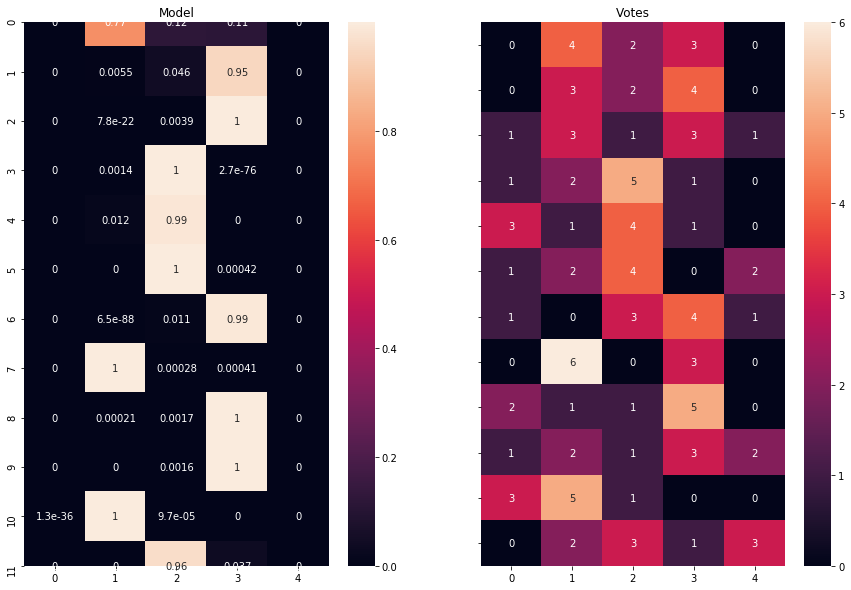

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 12

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

In [149]:
#For model b:

#Sum of each row of the votes totals the number of participants who responded to my survey. 
#The heatmap on the left respresents posterior probabilities while the heatmap on the right
#corresponds to freqencies.
#Modelb is certain that the "true answer" for question 3 is 2 (the white squares correspond to more certainty)
#The relationship between majority vote and the estimates is interesting. THe fourth column and second row value,
#"4" in the vote frequency heatmap, corersponds to a probability of .95 (more specifically, 95% probability
#that it's the "true answer"). - which makes sense, given that 4 is a lot
#of votes. However, there are also cases where comparatively lower numbers of votes correspond to higher 
#probabilities, like column 2, row 5 in the voter heat map, voter count 1, corresponds to a higher corresponding
#probabilty (0.012) than its neighbor to the left, 3 (0 prob). This makes sense given that there are 
#multiple factors that the model is using to predict the "true value" for a question, not just voter frequency
#(or, majority vote).


This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [109]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0)) #variability for each score (mean value of a particular class)

[[[0.68345722 0.1409645  0.08256458 0.04109471 0.05191899]
  [0.11403459 0.59526835 0.20184637 0.06695122 0.02189946]
  [0.07007752 0.10661518 0.59282338 0.13603291 0.09445102]
  [0.00910375 0.1071063  0.10150435 0.60824288 0.17404272]
  [0.09369981 0.01637355 0.16288119 0.14779165 0.5792538 ]]

 [[0.63067461 0.19262595 0.10254362 0.03357987 0.04057595]
  [0.20693736 0.54620179 0.14206935 0.05239893 0.05239256]
  [0.05669504 0.17347318 0.58315118 0.12199503 0.06468557]
  [0.08422644 0.06532507 0.18276349 0.50275791 0.16492708]
  [0.04575602 0.01847893 0.06069046 0.15488357 0.72019102]]

 [[0.71618928 0.17062669 0.04819142 0.01718256 0.04781006]
  [0.11616915 0.64823601 0.13226942 0.06077333 0.04255209]
  [0.05898669 0.18924915 0.48172162 0.15804484 0.1119977 ]
  [0.06837171 0.07340177 0.18929117 0.54607201 0.12286334]
  [0.02486598 0.04962595 0.04774829 0.16274257 0.71501721]]

 [[0.65829435 0.17007305 0.07302477 0.05068321 0.04792462]
  [0.18075283 0.56060678 0.13063789 0.09099874 0.0

Let's try everything again with ModelBt

In [110]:
# create a new instance of model B, with 5 label classes and 9 annotators.
model = ModelBt.create_initial_state(5, 9)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.87636637 0.70619674 0.93710232 0.90206081 0.82002759 0.80720385
 0.7875665  0.76573254 0.74470629]
-211.5749269444824


In [111]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.72131847 0.21414029 0.4623914  0.59520833 0.62159435 0.3791558
 0.67290079 0.37183844 0.48354236]
-162.26345065771923


In [150]:
posterior2 = model.infer_labels(anno.annotations)
print(posterior2)

[[3.39093961e-04 8.23766133e-01 4.05941457e-03 1.71835358e-01
  7.97935395e-10]
 [1.09928940e-04 5.35754720e-03 3.68794370e-03 9.90844580e-01
  2.58678131e-10]
 [6.73792297e-04 4.25443624e-02 3.40467028e-04 9.56441373e-01
  4.80815768e-09]
 [5.67446217e-05 5.21228881e-05 9.99876628e-01 1.45045768e-05
  1.72839863e-11]
 [3.35356249e-01 1.02723218e-03 6.62776668e-01 8.39850481e-04
  7.94746821e-10]
 [5.52832385e-04 1.88971897e-04 9.99189158e-01 6.90111018e-05
  2.69263884e-08]
 [2.85962348e-04 1.19606177e-05 1.28628467e-03 9.98415791e-01
  1.63531481e-09]
 [9.50584234e-06 9.96656879e-01 3.81441198e-06 3.32980086e-03
  2.23685731e-11]
 [7.59789109e-04 5.63054460e-05 1.46859338e-05 9.99169219e-01
  3.38056093e-11]
 [7.72705794e-04 7.12699812e-03 3.90447986e-04 9.91709806e-01
  4.17495892e-08]
 [2.32139346e-02 9.75040118e-01 1.64888960e-03 9.70572897e-05
  2.94639177e-10]
 [7.92919662e-04 1.35504707e-02 9.78458705e-01 7.19776075e-03
  1.43644778e-07]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

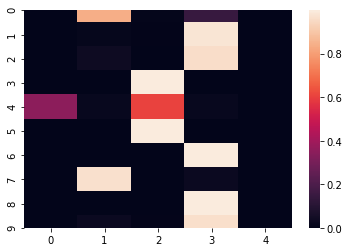

In [160]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()


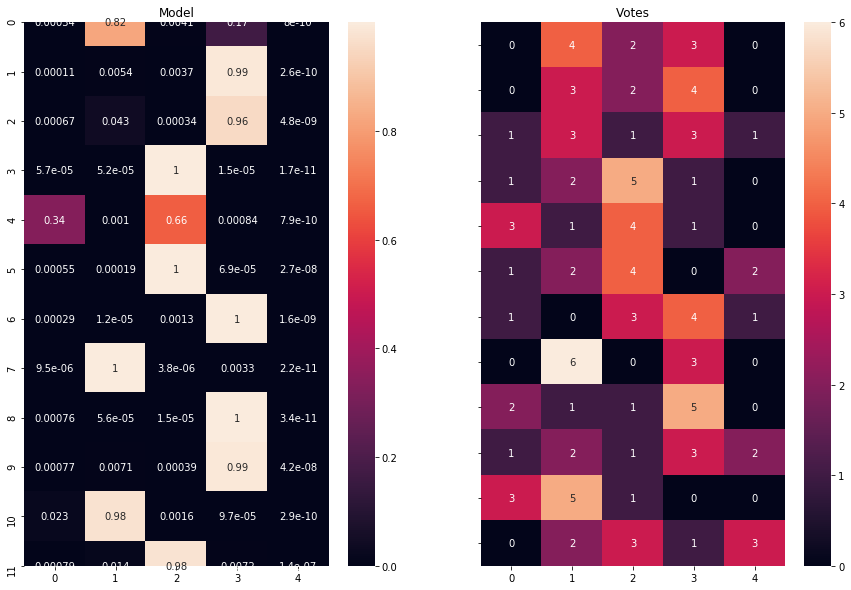

In [159]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 12

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior2[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

#For Model b theta

#Sum of each row of the votes totals the number of participants who responded to my survey. 
#The heatmap on the left respresents posterior probabilities while the heatmap on the right
#corresponds to freqencies.

#This is the heat map for the second model. Humans can give correct and wrong answers, so the model 
#uses all this information to give us the best estimate of each question. Given the knowledge
#that not all our coders are accurate, here's the "correct" answer. Like in the previous heatmap set 
#from modelB. The fact that we don't have a concrete value established for question 4 shows an unstable answer;
#it hasn't landed on a concrete estimate here. However, for the questions with white squares, it has,
#and determines this from the vote frequency (among other factors). Still uncertain about the presence of 5's 
#and 6's here.
#For example: for question 7, the "True" answer is 1. FOr questoin 8, the "True" answer is 3.
#But, like the heatmaps produced from Modelb, some of the majority votes don't actually correspond with 
#the final answer you'd expect (i.e., a cell displays a majority vote and you might expect that to be
#more ilkely to be the true answer, but a cell with fewer votes actually shows a higher probability).
#I explain why in the model b section.

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [161]:
model = ModelBt.create_initial_state(5, 9, theta= model.theta)
#random generate annotations with 5 label classes and 9 annotators
model.generate_annotations(20)
#This is what the model expects if you had 9 annotators and 5 classes, this is what they would predict for 
#each question.

array([[1, 3, 2, 1, 1, 4, 1, 1, 0],
       [2, 1, 3, 2, 3, 4, 2, 1, 2],
       [3, 3, 1, 1, 4, 0, 1, 1, 3],
       [2, 0, 3, 3, 3, 3, 3, 1, 1],
       [2, 1, 4, 2, 1, 1, 2, 1, 2],
       [0, 2, 0, 0, 2, 1, 0, 1, 4],
       [4, 4, 2, 3, 4, 2, 4, 2, 4],
       [4, 0, 2, 4, 4, 4, 0, 0, 1],
       [2, 0, 2, 2, 3, 2, 3, 4, 3],
       [1, 2, 2, 3, 2, 2, 2, 3, 3],
       [0, 4, 1, 4, 0, 0, 0, 1, 4],
       [0, 4, 0, 0, 0, 3, 0, 4, 0],
       [2, 1, 2, 2, 2, 0, 1, 1, 2],
       [2, 2, 2, 3, 1, 2, 2, 2, 2],
       [2, 3, 4, 4, 4, 4, 4, 2, 1],
       [2, 0, 4, 2, 2, 0, 4, 3, 2],
       [0, 2, 0, 0, 3, 0, 0, 3, 3],
       [2, 4, 2, 2, 2, 2, 4, 1, 4],
       [4, 2, 4, 3, 1, 1, 4, 4, 3],
       [3, 3, 3, 3, 3, 3, 0, 4, 4]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [156]:
model = ModelBt.create_initial_state(5, 9)
model.map(anno.annotations) #using MAP estimates, not MLE
samples = model.sample_posterior_over_accuracy(anno.annotations, 5, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

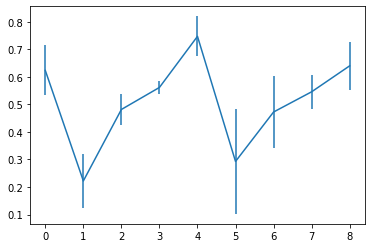

In [165]:
plt.figure()
plt.errorbar(range(9),y, yerr = y_ci)
plt.show()
#Mean values are center, and the variance is the error bars (length). So, this is an estimate of participant
#accuracy. 
#According to this, participant 5 has the most variation and also the lowest accuracy (worst coder)
#Our high quality analysts are those with the least variance (shortest variance bars) and highest value 
#on the y axis. So, our higher quality analysts are participants 0, 4, and 8 while our lowest quality 
#analysts are participants 1 and 5.
#These plots tell us about the distribution of skill among your coders (described above)
#the distribution in skill could be explained by cultural differences, mood, among other factors 